# Optimization for Data Science 2024 Homework 1

**Students:**

*Alberto Calabrese* - Student ID: 2103405

*Greta d'Amore Grelli* - Student ID: 2122424

*Eleonora Mesaglio* - Student ID: 2103402

*Marlon Helbing* - Student ID: 2106578

Let us consider $m$ samples described by $d$ features and divided in $k$ classes. We want to solve the multi-class classification problem of the form:

$$
\min_{X\in\R^{d\times k}} f(x) = \min_{X\in\R^{d\times k}} \sum_{i=1}^{m}\left[-x_{b_i}^Ta_i + \log\left(\sum_{c=1}^{k}\exp(x_c^Ta_i)\right)\right],
$$

where $a_i\in\R^d$ are the features of the $i$-th sample, $x_c\in\R^d$ is the column vector of the matrix of parameters $X\in\R^{d\times k}$ relating to class $c$ and $b_i\in\{1,\dots k\}$ is the label associated to the $i$-th sample, given by the following probability:

$$
P(b_i | X, a_i) = \frac{\exp(x_{b_i}^Ta_i)}{\sum_{c=1}^{k}\exp(x_c^Ta_i)}.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Set a seed for deterministic outputs
SEED = 42
np.random.seed(seed = SEED)

In [2]:
# Plotting functions
def plotting_GD(times,losses,gradient_norms):
    # Plotting loss vs time
    plt.figure(figsize=(10, 6))
    plt.plot(times, losses)
    plt.xlabel('CPU time (seconds)')
    plt.ylabel('Objective function')
    plt.title('Objective function vs CPU time - Gradient Descent')
   # plt.yscale("log")
    plt.show()

    # Plotting gradient norm across iterations
    plt.figure(figsize=(10, 6))
    plt.plot(gradient_norms, label = 'Gradient Norm')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm across Iterations - Gradient Descent')
   # plt.yscale("log")
    plt.show()

def plotting_RAND(times,losses,gradient_norms):
    # Plotting loss vs time
    plt.figure(figsize=(10, 6))
    plt.plot(times, losses)
    plt.xlabel('CPU time (seconds)')
    plt.ylabel('Objective function')
    plt.title('Objective function vs CPU time - BCGD Randomized')
   # plt.yscale("log")
    plt.show()

    # Plotting gradient norm across iterations
    plt.figure(figsize=(10, 6))
    plt.plot(gradient_norms, label = 'Gradient Norm')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm across Iterations - BCGD Randomized')
   # plt.yscale("log")
    plt.show()

def plotting_SG(times,losses,gradient_norms):
    # Plotting loss vs time
    plt.figure(figsize=(10, 6))
    plt.plot(times, losses)
    plt.xlabel('CPU time (seconds)')
    plt.ylabel('Objective function')
    plt.title('Objective function vs CPU time - BCGD Gauss-Southwell')
   # plt.yscale("log")
    plt.show()

    # Plotting gradient norm across iterations
    plt.figure(figsize=(10, 6))
    plt.plot(gradient_norms, label = 'Gradient Norm')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm across Iterations - BCGD Gauss-Southwell')
   # plt.yscale("log")
    plt.show()

## 1. Generating the dataset

First of all we require to randomly generate the matrices $A\in\R^{m\times d}$ of the features, $X\in\R^{d\times k}$ of the parameters and $E\in\R^{m\times k}$, with entries from normal distribution.

In [3]:
NUM_SAMPLES = 1000
NUM_FEATURES = 1000
NUM_LABELS = 50
NUM_EXAMPLES = 1000

# A MATRIX
# Generate a 1000x1000 matrix with random samples from a standard normal distribution
# This is our data matrix, which contains 1000 samples (rows) with 1000 features each (columns)
data_matrix = np.random.normal(0, 1, size = (NUM_SAMPLES, NUM_FEATURES))
A = data_matrix 
# 'A' contains random values drawn from N(0,1)
print("A shape: ", A.shape)

# X MATRIX
# This is our weight matrix that we initialize like this ; these weights we want to learn
# it has 1000 features (rows) with 50 labels each (columns)
weight_matrix = np.random.normal(0, 1, size = (NUM_FEATURES, NUM_LABELS))
X = weight_matrix
# 'X' contains random values drawn from N(0,1)
print("X shape: ", X.shape)

# E MATRIX
# This matrix is used to help generating our supervised gold labels 
# It is of size 1000 training examples (rows) and their labels (columns)
generative_matrix = np.random.normal(0, 1, size = (NUM_EXAMPLES, NUM_LABELS))
E = generative_matrix
# 'E' contains random values drawn from N(0,1)
print("E shape: ", E.shape)

# LABEL VECTOR
# Create a vector with numbers from 1 to 50
label_vector = np.arange(1, 51)

# Now calculate AX+E to generate labels for the 1000 training examples (such that we have a supervised learning set) 

result_matrix = A @ X + E

print("AX+E shape: ", result_matrix.shape)

A shape:  (1000, 1000)
X shape:  (1000, 50)
E shape:  (1000, 50)
AX+E shape:  (1000, 50)


## 2. MAX INDEX AS CLASS LABEL

Now, the labels $b_i$ of the $i$-th sample are chosen by considering $i$-th row of the following matrix $$B = AX + E$$ and taking as $b_i$ the column index with maximum value. 

We generate those labels by creating the vector $labels\in\R^{m}$ that in position $i$ has the label $b_i$ of the $i$-th sample.


In [4]:
# We find our labels by considering the max index in the row as the class label
# Find the column indices of maximum values for each row
labels = np.argmax(result_matrix, axis=1)
print("Labels shape: ", labels.shape)

# 'labels' now contains the column indices of maximum values for each row

Labels shape:  (1000,)


In [5]:
m = NUM_SAMPLES # samples
d = NUM_FEATURES # features
k = NUM_LABELS   # labels

## 3. Cost function 

Sure, here is the markdown version of your LaTeX text without double dollar signs:

In order to construct an efficient algorithm, it is useful to re-write the functions we need to implement (in our case the cost function $f$ and the respective gradient) in a more compact way.

Let us start with the cost function $f$:
$$
f(x) = \sum_{i=1}^{m}\left[-x_{b_i}^Ta_i + \log\left(\sum_{c=1}^{k}\exp(x_c^Ta_i)\right)\right]
     = \sum_{i=1}^m\left(f_i^1 + f_i^2\right)
     = \left(f^1+f^2\right)^T\mathbf{1}_m,
$$
where $\mathbf{1}_m \in\R^m$ is a vector only containing $1$'s and $f^1, f^2\in\R^m$ contain in position $i$, respectively, $f_i^1$ and $f^2_i$.

To obtain the first term $f^1$ we have to consider the column of the matrix $X$ corresponding to the class $b_i$ of the $i$-th sample, $x_{b_i}$ and the vector of features $a_i$, that is the $i$-th column of the matrix $A^T$. We can use the matrices $A$, $X$ and a matrix that contains the information about the classes of each sample to extract the elements that we want. Indeed, defining the indicator vectors $I_{b_i}\in\R^k$ as:

$$
(I_{b_i})_j = 
\begin{cases}
    1 & \text{if } b_i=j \\
    0 & \text{otherwise}
\end{cases} \quad \quad \text{for } j=1,\dots k,
$$
and so the indicator matrix $I_b$ as

$$
I_b = 
\begin{bmatrix}
    I_{b_1}, \dots I_{b_m}
\end{bmatrix}
$$

we get a matrix in $\R^{k\times m}$ that encodes for each sample $i$ the respective class $b_i$. At this point, it is easy to see that the elements we need are on the diagonal of the matrix $(AX)^T\cdot I_b$. Therefore, we able to re-write the vector $f^1$ using the fact that
$$
f^1_i=\left[(AX)^T\cdot I_b \right]_{ii}.
$$
From now on, we will use the following notation for $f^1$:
$$
    f^1= - \text{diag}\left((AX)^T\cdot I_b \right).
$$

Now, let us focus on the second term $f^2$. Taking into consideration the same matrices $A$, $X$ as before and using a vector $\mathbf{1}_k\in\R^k$ to sum over the rows of the matrix $\exp(AX)$, we can simply write
$$
    f^2 = \log(\exp(AX)\cdot \mathbf{1}_k).
$$
All in all, our cost function has the following form:
$$
    f = \left(-\text{diag}\left((AX)^T\cdot I_b\right) + \log\left(\exp(AX)\cdot \mathbf{1}_k\right)\right)^T\cdot\mathbf{1}_m.
$$

In [6]:
# Preparation for cost function

# Encoding I_b
# Since The labels stay the same over all iterations of our gradient descent algorithms, we will encode it before using the cost function,
# simply because else it would be more expensive

I_b = np.zeros((k,m))
# Iterate over all the labels 
for idx,label in enumerate(labels):
    indicator = np.zeros((k)) # Set to all 0's 
    indicator[label] = 1 # Set 1 at the index of the label (since we have 0 to 49, we can directly use label instead of label+1)
    I_b[:,idx] = indicator

In [7]:
def cost_function_3(X,A,labels):
    # X : d x k
    # A : m x d
    # AX : m x k
    # matrix I_b (indicator) encodes the labels b_i for each sample, thus it has form k x m (each column is indicator, where only at index b_i (label of i) is 1, else 0)
    # AX @  I_b
    # from this final matrix, we take just the diagonal entries 
    # we get a vector of size (m,)

    term_1 = -1 * (np.diag((A @ X) @ I_b))
    
    term_2 = np.exp(A @ X) @ np.ones((k,1))

    final = (term_1 + (np.log(term_2)).flatten()) @ np.ones((m,1))

    return final  

## 4. Hyperparameters

In [8]:
# Define Gradient descent variables
EPSILON = 1e-6
ITERATIONS = 1000
LR_GD = 0.001
LR_BCGD = 0.00008
LR_BCGD_GS = 0.00008

In [9]:
class LearningRateScheduler:
    def __init__(self, initial_lr, decay_factor, num_iterations_per_decay):
        """
        Initialize the learning rate scheduler.

        Args:
            initial_lr (float): Initial learning rate.
            decay_factor (float): Factor by which to decrease the learning rate.
            num_iterations_per_decay (int): Number of iterations before applying decay.
        """
        self.lr = initial_lr
        self.decay_factor = decay_factor
        self.num_iterations_per_decay = num_iterations_per_decay
        self.iteration_count = 0

    def get_learning_rate(self):
        """
        Get the current learning rate.

        Returns:
            float: Current learning rate.
        """
        return self.lr

    def update_learning_rate(self):
        """
        Update the learning rate based on the iteration count.
        """
        if self.iteration_count % self.num_iterations_per_decay == 0:
            self.lr *= self.decay_factor
        self.iteration_count += 1

In [10]:
#scheduler_GD = LearningRateScheduler(initial_lr=LR_GD, decay_factor=1, num_iterations_per_decay=100)
scheduler_BCGD = LearningRateScheduler(initial_lr=LR_BCGD, decay_factor=0.50, num_iterations_per_decay=50)
scheduler_BCGD_GS = LearningRateScheduler(initial_lr=LR_BCGD_GS, decay_factor=0.50, num_iterations_per_decay=50)

## 5.Partial Gradient
We define as a block a single column in the parameter matrix $X$. Thus, one block defines all features for a single class. As this is a column vector in the matrix $X$, our partial gradient is now only dependent on $c$.

Then, our partial derivatives with respect with one block have the following form

\begin{equation}
\frac{\partial f(X)}{\partial X_{c}} = - A^{T} \cdot (I_c - Q_c) = A^{T} \cdot (Q_c - I_c)
\end{equation}


where 

$A$ has shape $m \times d$, it is our given matrix A;
\
$I_c$ has shape $m \times 1$, it is the indicator vector containing $1$'s only at the positions where the label of the current sample $i$ is $c$ and $0$'s everywhere else;
$$
I_c=\begin{cases}
			1 \quad & \text{if $label_{i} = c $}\\
            0 \quad & \text{otherwise}
		 \end{cases}
$$
\
$Q_c$ has shape $m \times 1$, it is the vector calculating the exponential expression $\dfrac{\exp(x_{c}^{T}a_{i})}{\sum_{c' = 1}^{k} \exp(x_{c'}^{T}a_{i}) }$ for each sample $i$.

Thus, our result will be of form $d \times 1$.

Note that the calculations needed for $I_c$ and $Q_c$ only depend on $c$ and $i$. However, as we know all the samples $i$, we construct the vectors $I_c$ and $Q_c$ which are then only dependent on $c$.

In [11]:
# Gradient preparations

# Calculating the label encoder I_c
# We calculate once the encoding for all classes (I)
# I is of size (m,k)

I = np.zeros((m,k))
for label_idx in range(k):

    I[:,label_idx] = np.eye(k)[labels][:, label_idx]

In [12]:
def partial_gradient(X,A,labels,c):
    # We need X as parameter so it changes value across diff gradients
    # We define the partial gradient
    # Get the right indicator by selecting the column of the right class

    I_c = I[:,c]

    # Calculating vector Q for class c
    # use flatten to push it into (1000,)
    Q_c = np.exp(A @ X[:, c]) / ((np.exp(A @ X) @ np.ones((k,1))).flatten())

    return A.T @ (Q_c - I_c)

## 6. Full gradient

In [13]:
def full_gradient_final(X,A,labels):

    return (-1 * A.T) @ (I - ((np.exp(A @ X)) / (np.exp(A @ X) @ np.ones((k,1)))))

## 7. Gradient Descent Algorithm

In [14]:
def gradient_descent_final(X,A,labels,lr, iterations):

    gradient_norms = []
    X_values = []
    times = []
    start_time = time.time()
    for i in range(iterations):

        # Add values of X for to plot loss out of gradient calculation function 
        # (for better time efficiency in calculating the gradient)
        X_values.append(X)
        # Calculate gradient
        grad = full_gradient_final(X,A,labels)
        # Get the gradient norm
        norm = np.linalg.norm(grad)
        # Check the stopping criterium
        if norm < EPSILON:
            break
        # Add current gradient norm to list
        gradient_norms.append(norm)

        # Update the learning rate
        # current_lr = scheduler_GD.get_learning_rate()
        # print(f"Epoch {i + 1}: Learning rate = {current_lr:.6f}")
        # scheduler_GD.update_learning_rate()
        
        # Gradient step
        X = X - lr * grad
        # Add times
        times.append(time.time() - start_time)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    return X_values, gradient_norms, times

Execution time: 12.359169006347656 seconds


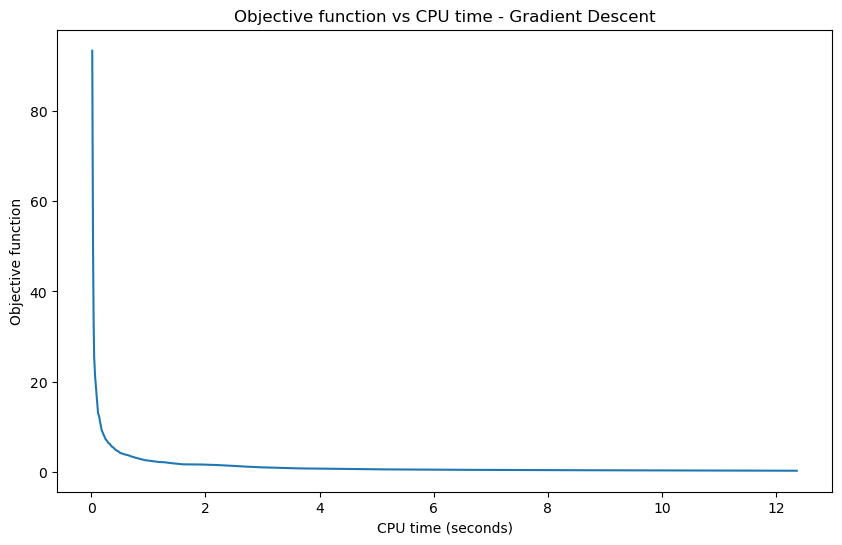

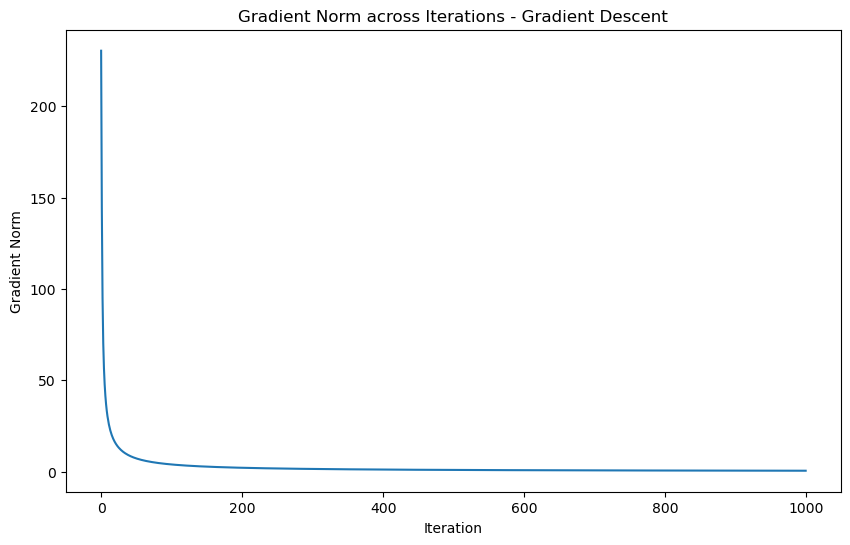

In [15]:
X_values, gradient_norms_GD, times_GD = gradient_descent_final(X,A,labels, lr= LR_GD, iterations= ITERATIONS)

losses_GD = [cost_function_3(X_val, A, labels) for X_val in X_values]

plotting_GD(times_GD,losses_GD,gradient_norms_GD)

## 8. BCGD Randomized Rule

In [16]:
# Generate the list of random choices of classes beforehand 
random_choices = []
for i in range(ITERATIONS):
    random_choices.append(random.randint(0,k-1)) 

In [17]:
def BCGD_randomized(X,A,labels,lr, iterations):
    # Do a copy of X so we don't change each time we run the program new
    X_copy = X.copy()

    gradient_norms = []
    X_values = []
    times = []
    start_time = time.time()

    # Calculate the full gradient once
    grad = full_gradient_final(X_copy,A,labels)

    for i in range(iterations): 
        # Add values of X for to plot loss out of gradient calculation function (for better time efficiency in calculating the gradient)
        # why do we have to use np.copy again ? else constant value ???
        X_values.append(np.copy(X_copy))

        # Generate random c
        curr_c = random_choices[i] #random.randint(0,k-1)

        # Take the random block
        curr_grad = grad[:, curr_c]

        grad[:, curr_c] = partial_gradient(X_copy,A,labels,curr_c) 
      
        # Get the gradient norm (of the whole gradient)
        norm = np.linalg.norm(grad)
        # Check the stopping criterium
        # Not added here, because we can always only calc norm of 
        # current partial gradient : better just do via iterations ?

        # Update the learning rate
        current_lr = scheduler_BCGD.get_learning_rate()
        # print(f"Epoch {i + 1}: Learning rate = {current_lr:.6f}")
        scheduler_BCGD.update_learning_rate()
  
        # Add current gradient norm to list
        gradient_norms.append(norm)
        # Gradient step
        X_copy = X_copy - lr * grad
        # Add times
        times.append(time.time() - start_time)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    return X_values, gradient_norms, times

Execution time: 4.130918741226196 seconds


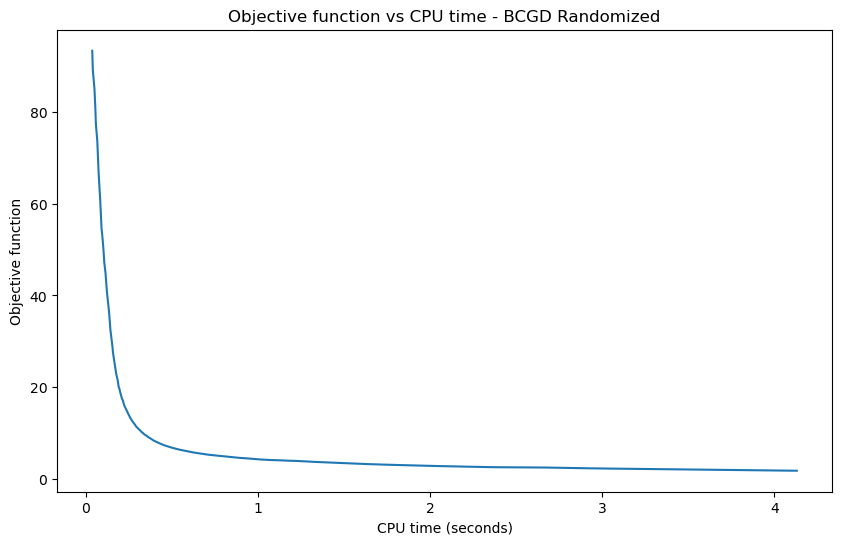

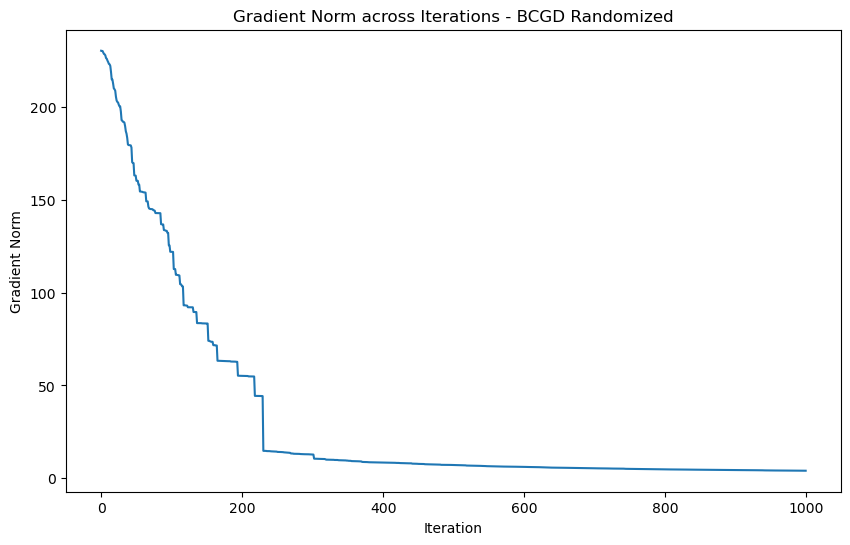

In [18]:
X_values, gradient_norms_BCGD, times_BCGD = BCGD_randomized(X,A,labels, lr = LR_BCGD, iterations= ITERATIONS)

losses_BCGD = [cost_function_3(X_val, A, labels) for X_val in X_values]

plotting_RAND(times_BCGD, losses_BCGD, gradient_norms_BCGD)

## 9. BCGD Gauss-Southwell Algorithm

In [19]:
def Gauss_Southwell_final(X,A, labels,lr, iterations):
    # Calculate all partial gradients once, then just update on the one with biggest norm
    # Then, recalculate the norm of the just updated one and see if there is now a bigger one, then choose the bigger one

    # Start off with a copy of X
    X_copy = X.copy()

    gradient_norms = []
    X_values = []
    times = []
    start_time = time.time()

    # Calculate the full gradient once
    grad = full_gradient_final(X_copy,A,labels)

    # Calculate the norms 
    norms = np.linalg.norm(grad, axis=0)

    # Initialize a random column index as the max norm
    max_norm_class_index = 0

    for it in range(iterations): # iterations
        # In each iteration, check if there is a new maximal norm : Choose the biggest one for updating

        # Add values of X for to plot loss out of gradient calculation function (for better time efficiency in calculating the gradient)
        # why do we have to use np.copy again ? else constant value ???
        X_values.append(np.copy(X_copy))
        
        # In the first iteration, we already calculated gradients for all blocks, so we do the updating only starting
        # at the second iteration
        if it > 0:
            # Recalculate the gradient of the block gradient we updated
            grad[:, max_norm_class_index] = partial_gradient(X_copy,A,labels,c=max_norm_class_index)
            # Recalculate the norm of the block gradient we updated
            norms[max_norm_class_index] = np.linalg.norm(grad[:, max_norm_class_index])

        # Get sum of norms
        sum_norms = np.sum(norms)

        # Check the stopping criterium
        if sum_norms < EPSILON:
            break
        # Get the index of the column with the largest norm in the current iteration
        max_norm_class_index = np.argmax(norms)
 
        # Select the column with the largest norm
        max_norm_partial_grad = grad[:, max_norm_class_index]

        # Add gradient norm (of complete gradient)
        gradient_norms.append(sum_norms)

        # Update the learning rate
        current_lr = scheduler_BCGD_GS.get_learning_rate()
        # print(f"Epoch {i + 1}: Learning rate = {current_lr:.6f}")
        scheduler_BCGD_GS.update_learning_rate()
        
        # Gradient step
        X_copy = X_copy- lr * grad

        # Add times
        times.append(time.time() - start_time)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

    return X_values, gradient_norms, times

Execution time: 4.128611087799072 seconds


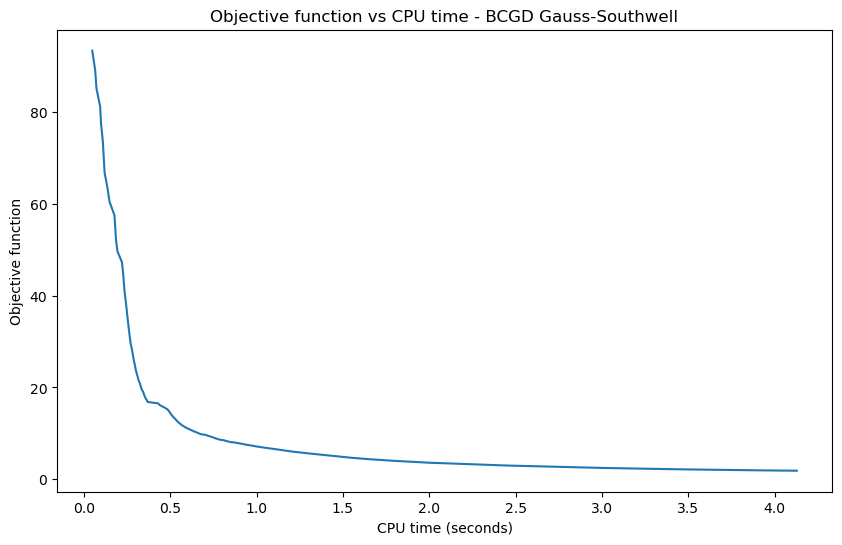

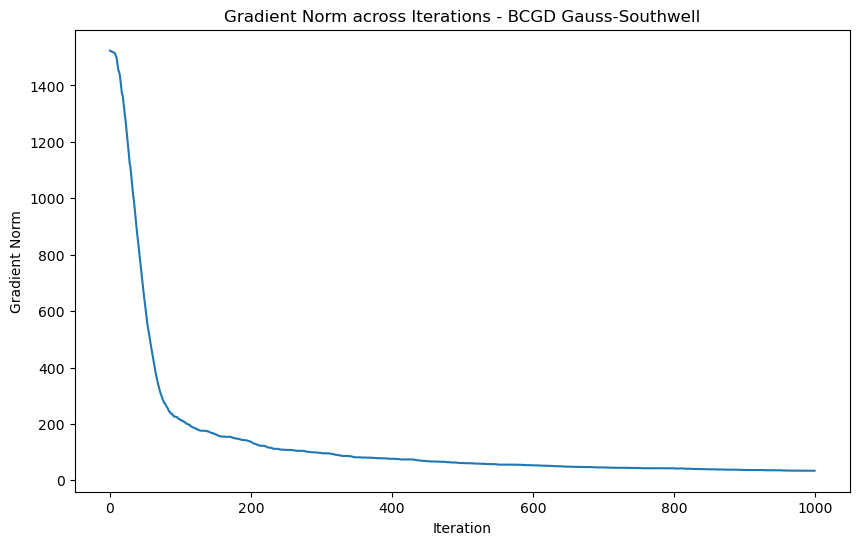

In [20]:
# Let's see how it performs
X_values_BCGD_GS, gradient_norms_BCGD_GS, times_BCGD_GS = Gauss_Southwell_final(X,A,labels,lr= LR_BCGD_GS, iterations= ITERATIONS)

losses_BCGD_GS = [cost_function_3(X_val, A, labels) for X_val in X_values_BCGD_GS]

plotting_SG(times_BCGD_GS, losses_BCGD_GS, gradient_norms_BCGD_GS)

## 10 Comparison between the models

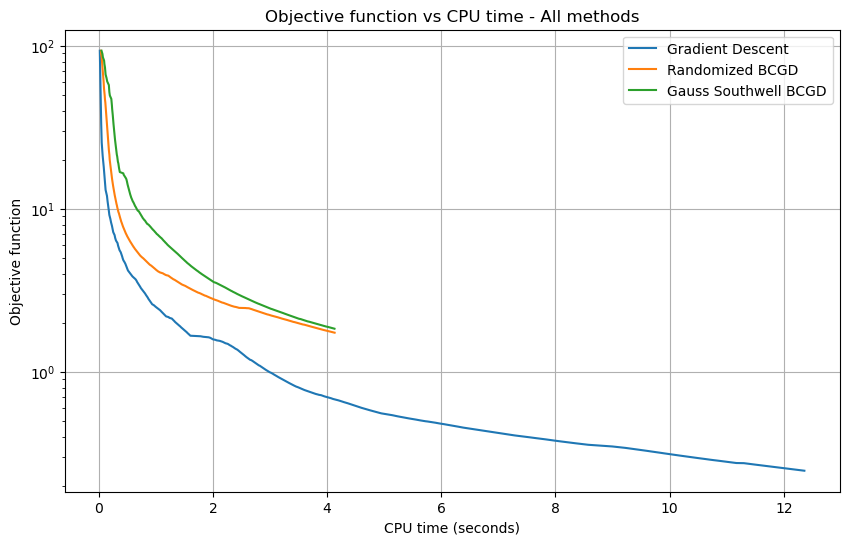

In [21]:
# Graph comparison of all three methods
plt.figure(figsize=(10, 6))
plt.plot(times_GD, losses_GD, label = 'Gradient Descent')
plt.plot(times_BCGD, losses_BCGD, label = 'Randomized BCGD')
plt.plot(times_BCGD_GS, losses_BCGD_GS, label = 'Gauss Southwell BCGD')
plt.xlabel('CPU time (seconds)')
plt.ylabel('Objective function')
plt.title('Objective function vs CPU time - All methods')
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

## 11 Real Dataset : Import, Exploration and Preparation

In [22]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 

# data (as pandas dataframes) 
X = optical_recognition_of_handwritten_digits.data.features 
y = optical_recognition_of_handwritten_digits.data.targets 

NUM_SAMPLES_ALL = X.shape[0]
NUM_FEATURES = X.shape[1]
NUM_LABELS = len(np.unique(y))

d = NUM_FEATURES
k = NUM_LABELS 

# Scale the data
scaler = StandardScaler()
# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

A = np.array(X)
labels = np.array(y)

# Split the data into training and test sets
A_train, A_test, labels_train, labels_test = train_test_split(A, labels, test_size=0.2, random_state=42)

# We will only use a train set, not validation, because we don't necessarily
# need hyperparameter tuning
m = A_train.shape[0]

## 12 Initiate Weight Matrix

In [23]:
weight_matrix = np.random.normal(0, 1, size = (d,k))
X = weight_matrix
print(X.shape)

(64, 10)


## 13 GD - Real Data

In [24]:
# Preparations
# Calculating the label encoder I_c
# We calculate once the encoding for all classes (I)
# I is of size (m,k)

I = np.zeros((m,k))
for label_idx in range(k):

    I[:,label_idx] = np.eye(k)[labels_train.flatten()][:, label_idx]

# Preparation for cost function

# Encoding I_b
# Since The labels stay the same over all iterations of our gradient descent algorithms, we will encode it before using the cost function,
# simply because else it would be more expensive

I_b = np.zeros((k,m))
# Iterate over all the labels 
for idx,label in enumerate(labels_train):
    indicator = np.zeros((k)) # Set to all 0's 
    indicator[label] = 1 # Set 1 at the index of the label (since we have 0 to 9, we can do it directly like that)
    I_b[:,idx] = indicator

Execution time: 2.1972310543060303 seconds


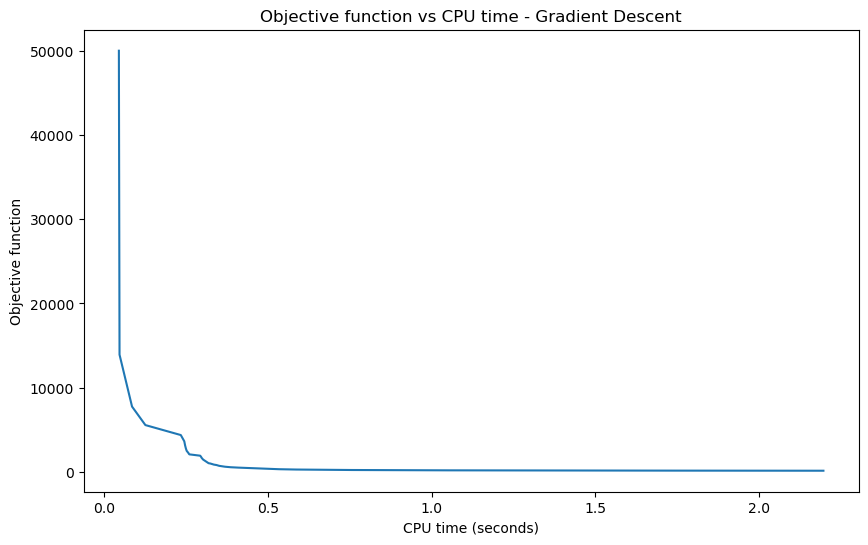

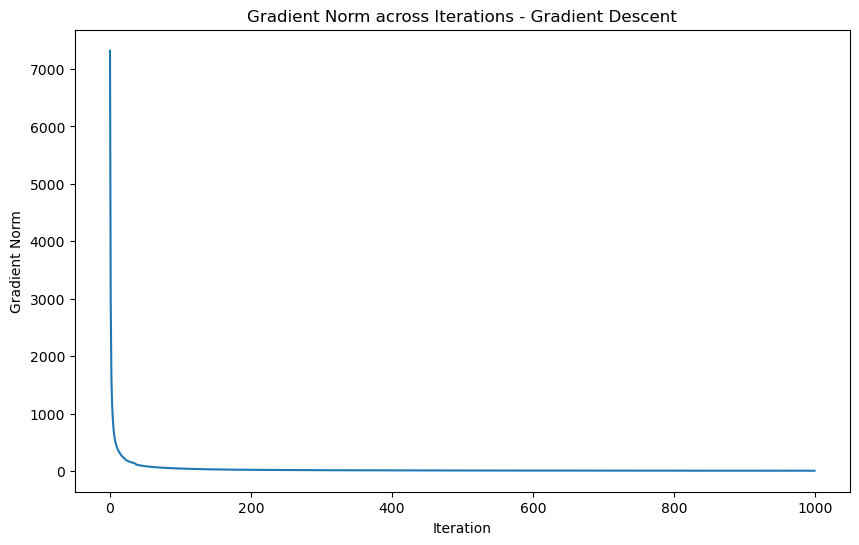

In [25]:
X_values_GD, gradient_norms_GD, times_GD = gradient_descent_final(X,A_train,labels_train, lr= LR_GD, iterations= ITERATIONS)

losses_GD = [cost_function_3(X_val, A_train, labels_train) for X_val in X_values_GD]

plotting_GD(times_GD,losses_GD,gradient_norms_GD)

## 14 BCGD Randomized - Real Data

In [26]:
# Generate the list of random choices of classes beforehand 
random_choices = []
for i in range(ITERATIONS): # 1000 Iterations
    random_choices.append(random.randint(0,k-1))

Execution time: 1.3919057846069336 seconds


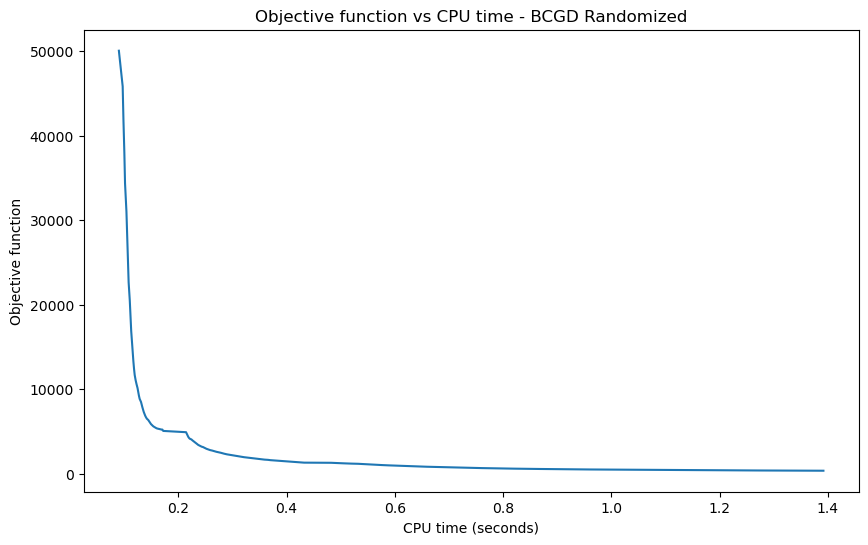

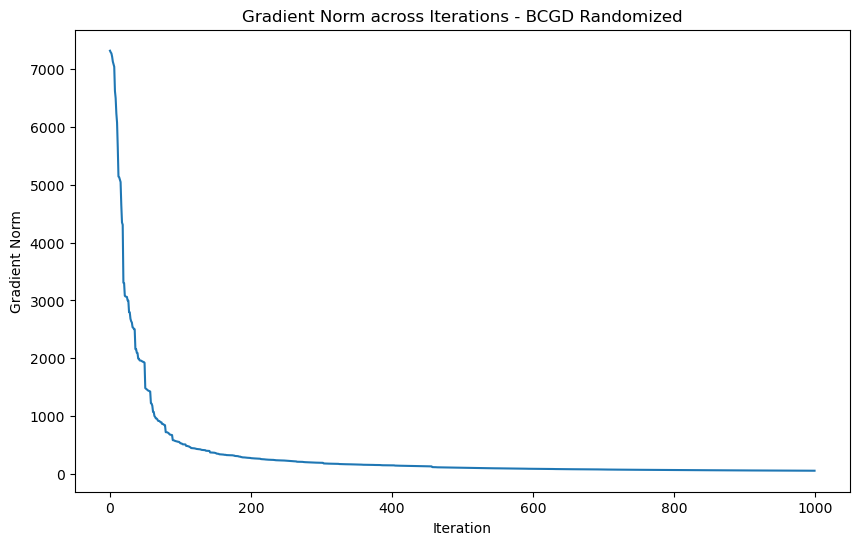

In [27]:
m = A_train.shape[0] # set m to training examples , need to put m as param into function

X_values_BCGD, gradient_norms_BCGD, times_BCGD = BCGD_randomized(X,A_train, labels_train,lr= LR_BCGD, iterations=ITERATIONS)
losses_BCGD = [cost_function_3(X_val, A_train, labels_train) for X_val in X_values_BCGD]

plotting_RAND(times_BCGD, losses_BCGD, gradient_norms_BCGD)

## 15 BCGD Gauss-Southwell - Real Data

Execution time: 1.2204480171203613 seconds


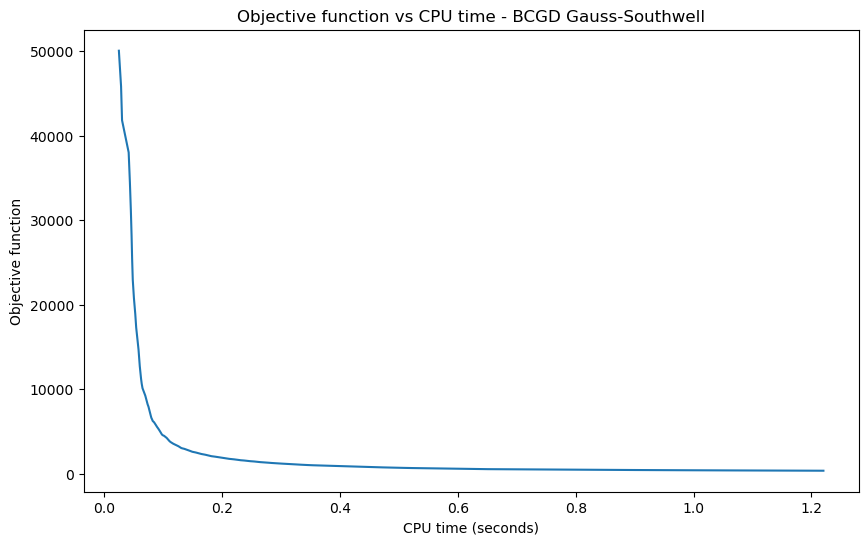

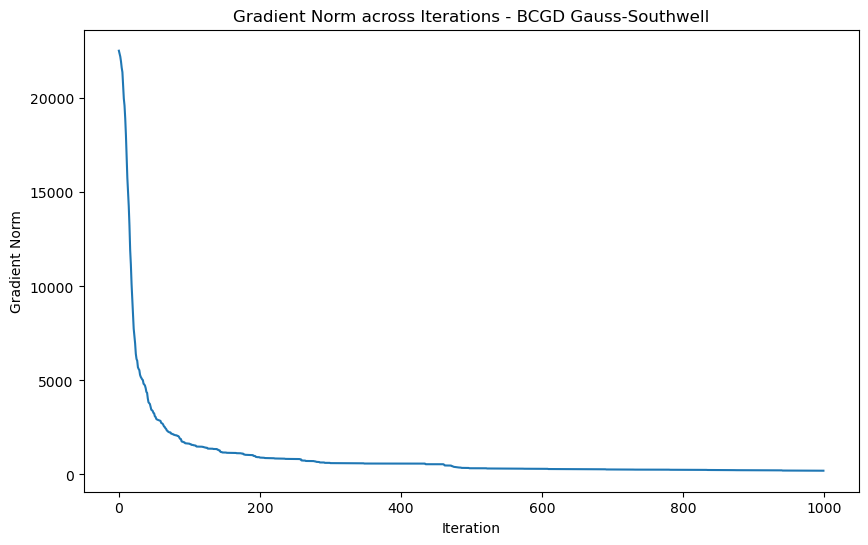

In [28]:
X_values_BCGD_GS, gradient_norms_BCGD_GS, times_BCGD_GS = Gauss_Southwell_final(X,A_train,labels_train,lr= LR_BCGD_GS, iterations= ITERATIONS)

losses_BCGD_GS = [cost_function_3(X_val, A_train, labels_train) for X_val in X_values_BCGD_GS]

plotting_SG(times_BCGD_GS, losses_BCGD_GS, gradient_norms_BCGD_GS)

## 16 Accuracy check on test set

In [29]:
def softmax(matrix):
    # Subtract max for numerical stability
    shift_matrix = matrix - np.max(matrix, axis=1, keepdims=True)
    exps = np.exp(shift_matrix)
    softmax_matrix = exps / np.sum(exps, axis=1, keepdims=True)
    return softmax_matrix

In [30]:
def accuracy(feature_matrix, data, labels):

    # initialize E, like we did to get the labels on the first dataset
    
    E = np.random.normal(0,1 , size = (A_test.shape[0],k))
 
    matrix = (data @ feature_matrix) + E

    softmax_results = softmax(matrix)

    labels_predicted = np.argmax(softmax_results, axis=1)

    same_values = (labels_predicted == labels.flatten())

    num_same_values = np.sum(same_values)

    accuracy = (num_same_values / labels.shape[0]) * 100

    return accuracy

In [31]:
accuracy_GD = accuracy(X_values_GD[-1], A_test, labels_test)
accuracy_BCGD = accuracy(X_values_BCGD[-1], A_test, labels_test)
accuracy_BCGD_GS = accuracy(X_values_BCGD_GS[-1], A_test, labels_test)

names = ['Gradient Descent Normal', 'Block Gradient Descent, Randomized', 'Block Gradient Descent, South Gauswell Rule']
accuracies = [accuracy_GD, accuracy_BCGD, accuracy_BCGD_GS]
for idx,_ in enumerate(accuracies):

    print("Accuracy of {} is {} percent".format(names[idx], accuracies[idx]))

Accuracy of Gradient Descent Normal is 95.8185053380783 percent
Accuracy of Block Gradient Descent, Randomized is 94.3950177935943 percent
Accuracy of Block Gradient Descent, South Gauswell Rule is 93.59430604982207 percent


## 17 Graph Comparison between the algorithms on real data

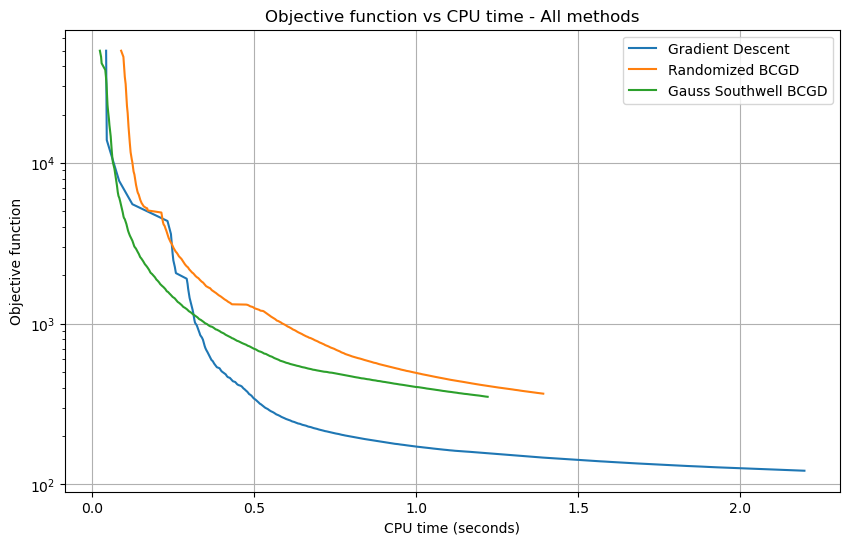

In [32]:
# Graph comparison of all three methods
plt.figure(figsize=(10, 6))
plt.plot(times_GD, losses_GD, label = 'Gradient Descent')
plt.plot(times_BCGD, losses_BCGD, label = 'Randomized BCGD')
plt.plot(times_BCGD_GS, losses_BCGD_GS, label = 'Gauss Southwell BCGD')
plt.xlabel('CPU time (seconds)')
plt.ylabel('Objective function')
plt.title('Objective function vs CPU time - All methods')
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()